# Autencoder
This notebook implements common autoencoders using pytorch. The training dataset is MNIST.

The types of autoencoders on this notebook are<a id=top>
1. [Basic AE](#basic)
2. [Conv AE](#conv)
3. [Denoising AE](#denoise)
4. Variational AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

batch_size = 64

# Download training and test data from open datasets.
training_data = datasets.MNIST(root="./datasets", train=True, transform=ToTensor(), download=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST(root="./datasets", train=False, transform=ToTensor(), download=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

dataiter = iter(train_dataloader)
img, lbl = next(dataiter)
print(torch.min(img), torch.max(img))

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



tensor(0.) tensor(1.)
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cuda device


## Basic Autoencoder <a id=basic>
[Back to top](#top)

In [26]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [49]:
model = Autoencoder().to(device)
print(model)
print(summary(model,input_size=(1,28*28)))  # torchinfo
loss_fn  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-8)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 784]                  --
├─Sequential: 1-1                        [1, 16]                   --
│    └─Linear: 2-1                       [1, 128]                  100,480
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 64]                   8,256
│    └─ReLU: 2-4                         [1, 

In [36]:
epochs = 10
outputs = []  # a list of [epoch count, ground truth, reconstructed img]
for epoch in range(epochs):
    for (img, _) in train_dataloader:
        img = img.to(device)
        img = img.reshape(-1,28*28)  # flatten the image
        recon = model(img)
        loss = loss_fn(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch 1, Loss:0.0213
Epoch 2, Loss:0.0175
Epoch 3, Loss:0.0135
Epoch 4, Loss:0.0168
Epoch 5, Loss:0.0162
Epoch 6, Loss:0.0130
Epoch 7, Loss:0.0158
Epoch 8, Loss:0.0154
Epoch 9, Loss:0.0162
Epoch 10, Loss:0.0173


In [39]:
import sys
print(f"{sys.getsizeof(outputs)} bytes")

184 bytes


Epoch: 1
Epoch: 5
Epoch: 9


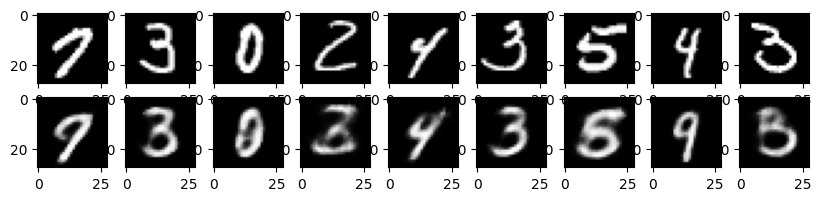

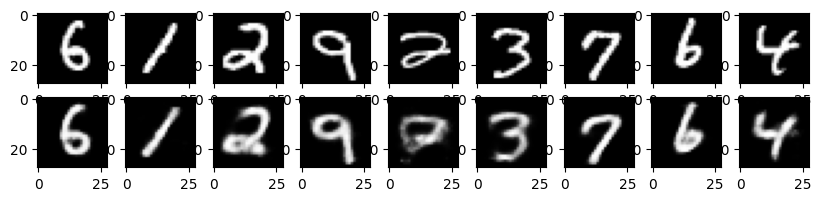

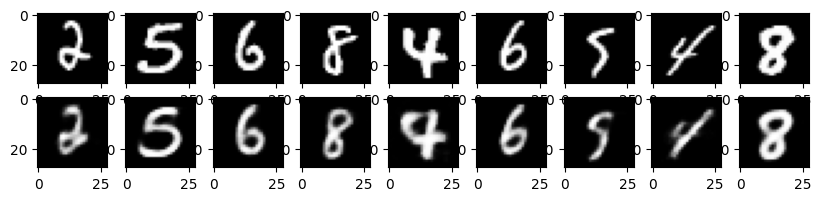

In [7]:
for k in range(0, epochs, 4):
    print(f"Epoch: {k+1}")

    plt.figure(figsize=(10,2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recons = outputs[k][2].cpu().detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break  # print nine digits
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)  # 'unflatten' the image 
        plt.imshow(item[0])

    for i, item in enumerate(recons):
        if i >= 9: break  # print nine digits
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)  # 'unflatten' the image 
        plt.imshow(item[0])

TypeError: Invalid shape (784,) for image data

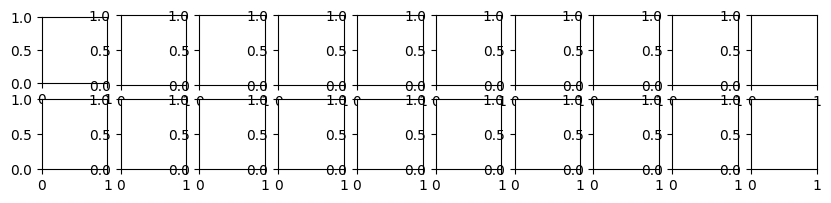

In [ ]:
# Visualize original and reconstructed images
fig, axs = plt.subplots(2, 10, figsize=(10, 2))
imgs = outputs[k][1].cpu().detach().numpy()
recons = outputs[k][2].cpu().detach().numpy()
with torch.no_grad():
    for i in range(10):
        axs[0, i].imshow(imgs[i].view(8, 8), cmap='gray')
        axs[1, i].imshow(recons[i].view(8, 8), cmap='gray')
plt.show()

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.reshape(-1,28*28)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.reshape(-1,28*28)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

# # Training loop
# epochs = 1
# for epoch in range(epochs):
#     output = model(train_dataloader)
#     loss = criterion(output, train_dataloader)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # Visualize original and reconstructed images
# fig, axs = plt.subplots(2, 10, figsize=(10, 2))
# with torch.no_grad():
#     for i in range(10):
#         axs[0, i].imshow(data[i].view(8, 8), cmap='gray')
#         axs[1, i].imshow(model(data[i]).view(8, 8), cmap='gray')
# plt.show()

Epoch 1
-------------------------------


/home/peka/prototypes/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (784) must match the size of tensor b (64) at non-singleton dimension 1

## Conv Autoencoder <a id=conv>
[Back to top](#top)

In [ ]:
# Define the Autoencoder
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # output_padding is needed to match the tensor sizes between layers
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = ConvAE().to(device)
print(model)
loss_fn  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-8)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [9]:
epochs = 10
outputs = []  # a list of [epoch count, ground truth, reconstructed img]
for epoch in range(epochs):
    for (img, _) in train_dataloader:
        img = img.to(device)
        recon = model(img)
        loss = loss_fn(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))


Epoch 1, Loss:0.0060
Epoch 2, Loss:0.0036
Epoch 3, Loss:0.0034
Epoch 4, Loss:0.0026
Epoch 5, Loss:0.0024
Epoch 6, Loss:0.0030
Epoch 7, Loss:0.0028
Epoch 8, Loss:0.0024
Epoch 9, Loss:0.0024
Epoch 10, Loss:0.0026


Epoch: 1
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.     

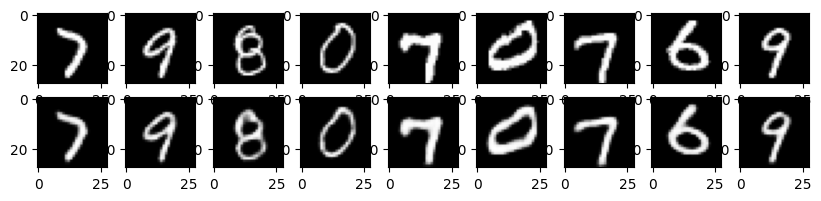

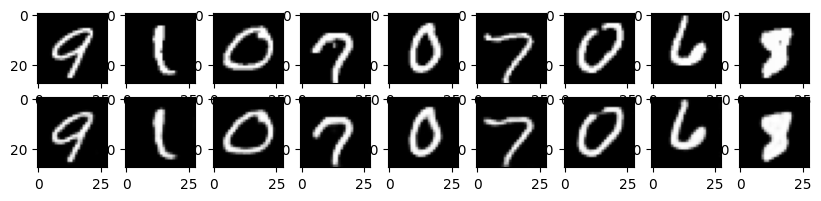

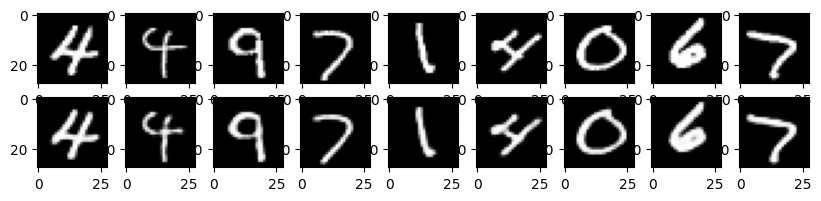

In [ ]:
for k in range(0, epochs, 4):
    print(f"Epoch: {k+1}")

    plt.figure(figsize=(10,2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recons = outputs[k][2].cpu().detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break  # print nine digits
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recons):
        if i >= 9: break  # print nine digits
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

## Denoising Autoencoder <a id=denoise>
[Back to top](#top)